# Importing Libraries

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb
from sklearn.metrics import roc_auc_score

import warnings

# Load the Data

In [2]:
train    = pd.read_csv(f"/kaggle/input/playground-series-s4e7/train.csv", index_col = "id")
test     = pd.read_csv(f"/kaggle/input/playground-series-s4e7/test.csv")
original = pd.read_csv(f"/kaggle/input/health-insurance-cross-sell-prediction-data/train.csv", index_col = "id")


train = pd.concat([train, original[train.columns]], axis=0, ignore_index = True)
train.index  = range(len(train))

# Dataset Overview

The dataset consists of the following columns:

- **id** : Unique identifier for each row.

- **Gender**: Gender of the insured.

- **Age**: Age of the insured.

- **Driving_License**: Whether the insured has a valid driving license (1: Yes, 0: No).

- **Region_Code**: Code for the region of the insured.

- **Previously_Insured**: Whether the insured has previously been insured

- **Vehicle_Age**: Age of the vehicle.(0-1,1-2,>2)

- **Vehicle_Damage**: Whether the insured vehicle has been damaged in the past (Yes/No).

- **Annual_Premium**: The annual premium amount.

- **Policy_Sales_Channel**: Sales channel code for the policy.

- **Vintage**: Number of days the insured has been associated with the company.

- **Response**: Target variable indicating whether the customer will respond positively (1: Yes, 0: No).

In [3]:
print(f'Train data:\nShape:\n{train.shape}')
print('=============================')
print(f'test data:\nShape:\n{test.shape}')

Train data:
Shape:
(11885907, 11)
test data:
Shape:
(7669866, 11)


In [4]:
print("Few rows of the train dataset:")
train.head(5)

Few rows of the train dataset:


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [5]:
# info
print('info of train data:\n', train.info())
print('info of test data:\n', test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11885907 entries, 0 to 11885906
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Gender                object 
 1   Age                   int64  
 2   Driving_License       int64  
 3   Region_Code           float64
 4   Previously_Insured    int64  
 5   Vehicle_Age           object 
 6   Vehicle_Damage        object 
 7   Annual_Premium        float64
 8   Policy_Sales_Channel  float64
 9   Vintage               int64  
 10  Response              int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 997.5+ MB
info of train data:
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7669866 entries, 0 to 7669865
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code 

# EDA

In [6]:
print(f'Null values in each column in train data:\n{train.isnull().sum()}')
print('========================================')
print(f'Null values in each column in test data:\n{test.isnull().sum()}')

Null values in each column in train data:
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64
Null values in each column in test data:
id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64


In [7]:
submission_id = test.id
test = test.drop(columns=['id'])

In [8]:
train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Gender,11885907,2,Male,6434223,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,11885907.0,NaN,NaN,NaN,38.39764,15.010549,20.0,24.0,36.0,49.0,85.0
Driving_License,11885907.0,NaN,NaN,NaN,0.998017,0.044486,0.0,1.0,1.0,1.0,1.0
Region_Code,11885907.0,NaN,NaN,NaN,26.417732,12.999299,0.0,15.0,28.0,35.0,52.0
Previously_Insured,11885907.0,NaN,NaN,NaN,0.462843,0.498617,0.0,0.0,0.0,1.0,1.0
Vehicle_Age,11885907,3,1-2 Year,6182994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle_Damage,11885907,2,Yes,5975642,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Annual_Premium,11885907.0,NaN,NaN,NaN,30464.673611,16479.613681,2630.0,25256.0,31820.0,39450.0,540165.0
Policy_Sales_Channel,11885907.0,NaN,NaN,NaN,112.4129,54.041153,1.0,29.0,151.0,152.0,163.0
Vintage,11885907.0,NaN,NaN,NaN,163.591522,80.118209,10.0,98.0,166.0,232.0,299.0


In [10]:
def plot_numerics(data):
    numeric_columns = ['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
    # Plotting histograms and box plots for each numeric column
    for column in numeric_columns:
        _, ax = plt.subplots(1,2, figsize=(16, 5))
        ax=ax.flatten()

        # Histogram
        #sns.histplot(data[column], bins=10, kde=True, color='skyblue', ax=ax[0])
        sns.histplot(data[column],kde=True, color='skyblue', ax=ax[0])
        ax[0].set_title(f'Histogram of {column}', fontsize=15,fontweight='bold')
        ax[0].set_xlabel(column, fontsize=12)
        ax[0].set_ylabel('Frequency', fontsize=12)

        # Box plot
        sns.boxplot(x=data[column], color='lightgreen', ax=ax[1])
        ax[1].set_title(f'Box plot of {column}', fontsize=15,fontweight='bold')
        ax[1].set_xlabel(column, fontsize=12)

        plt.tight_layout()
        plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


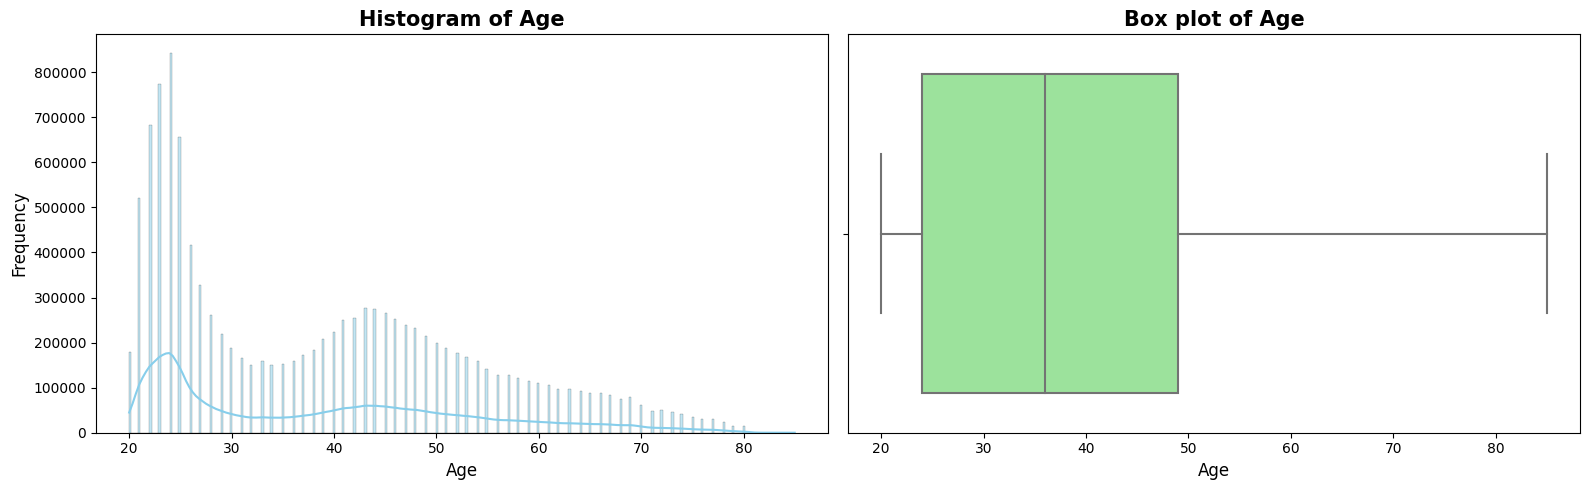

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


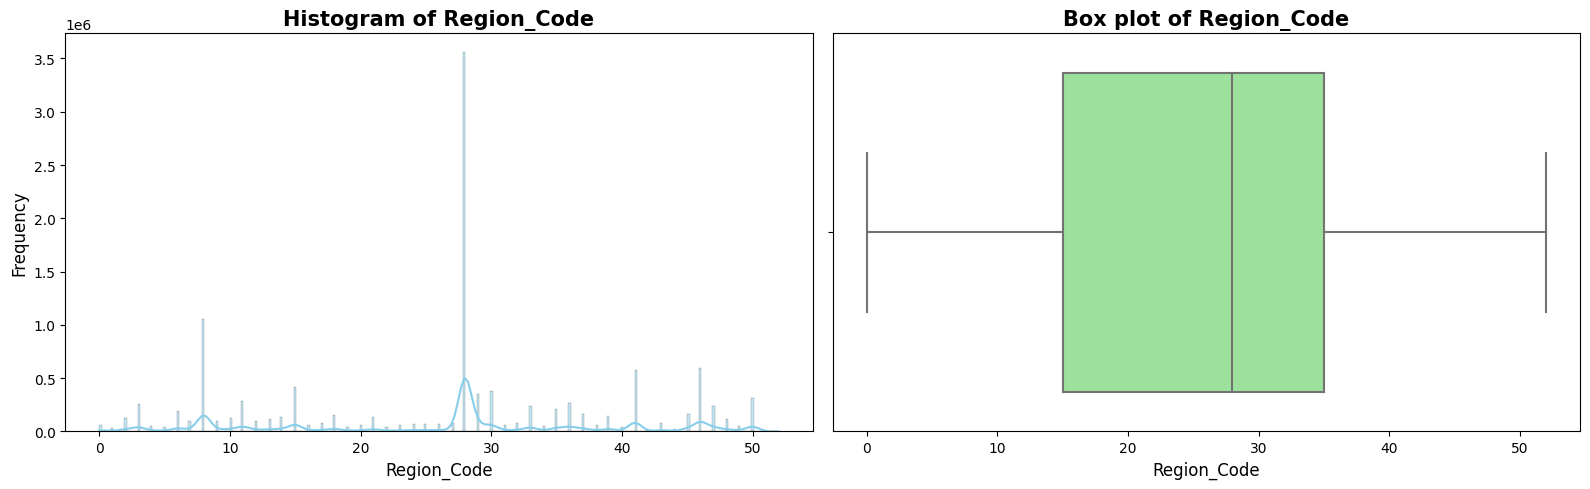

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


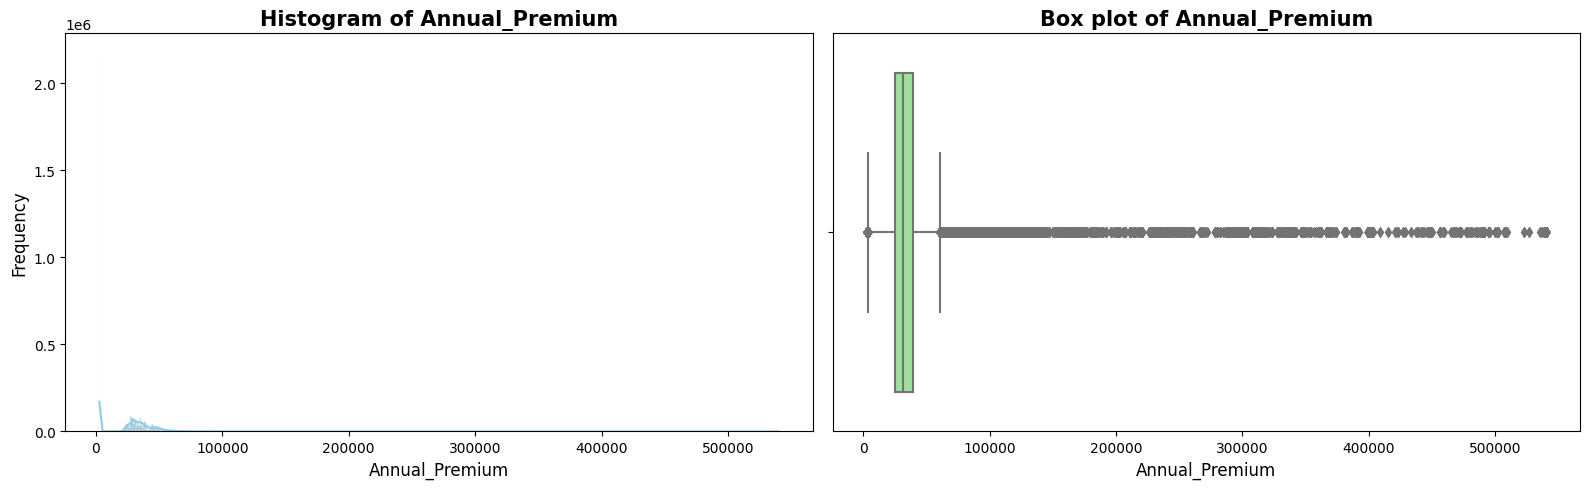

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


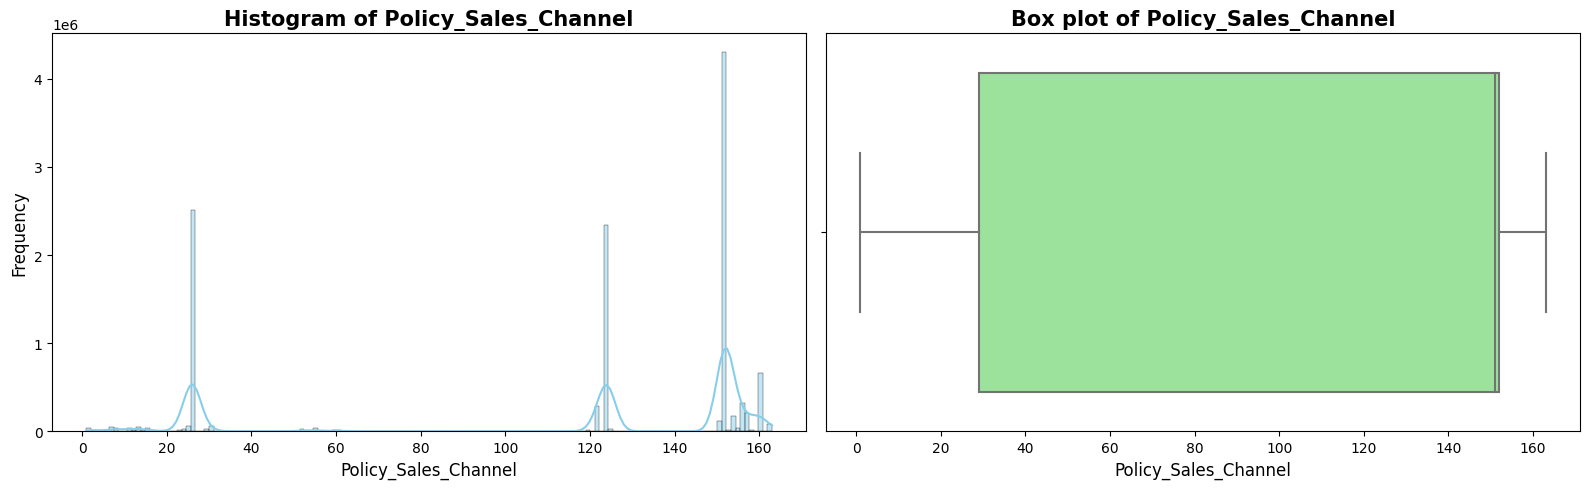

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


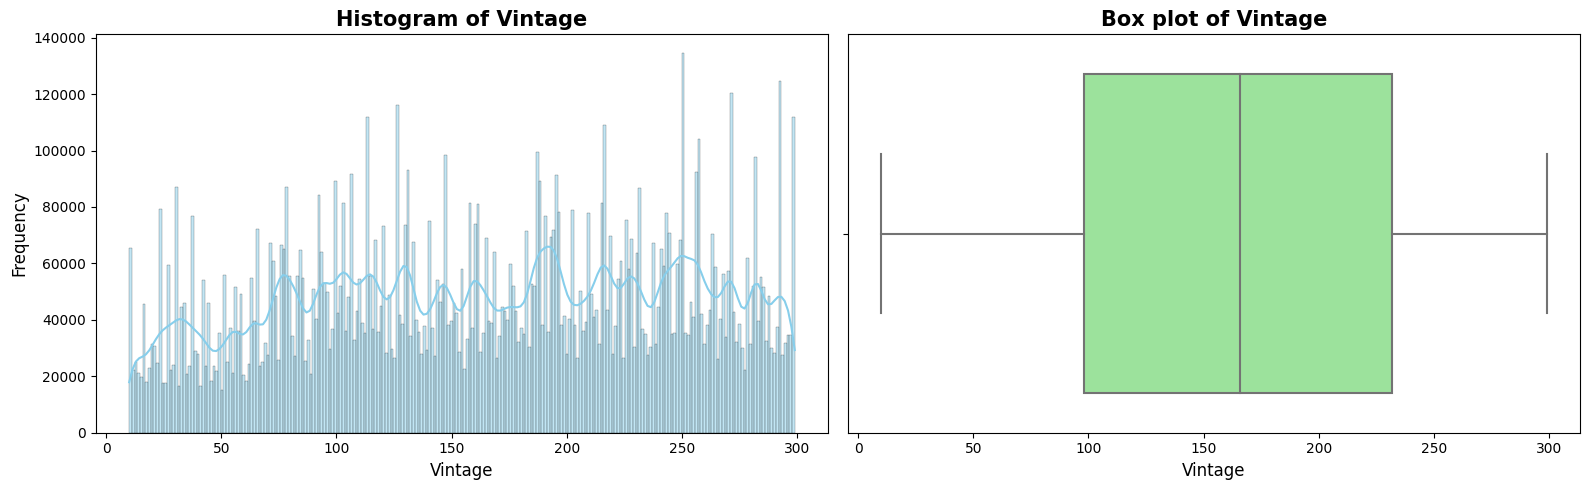

In [30]:
numeric_columns = ['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
plot_numerics(train[numeric_columns])

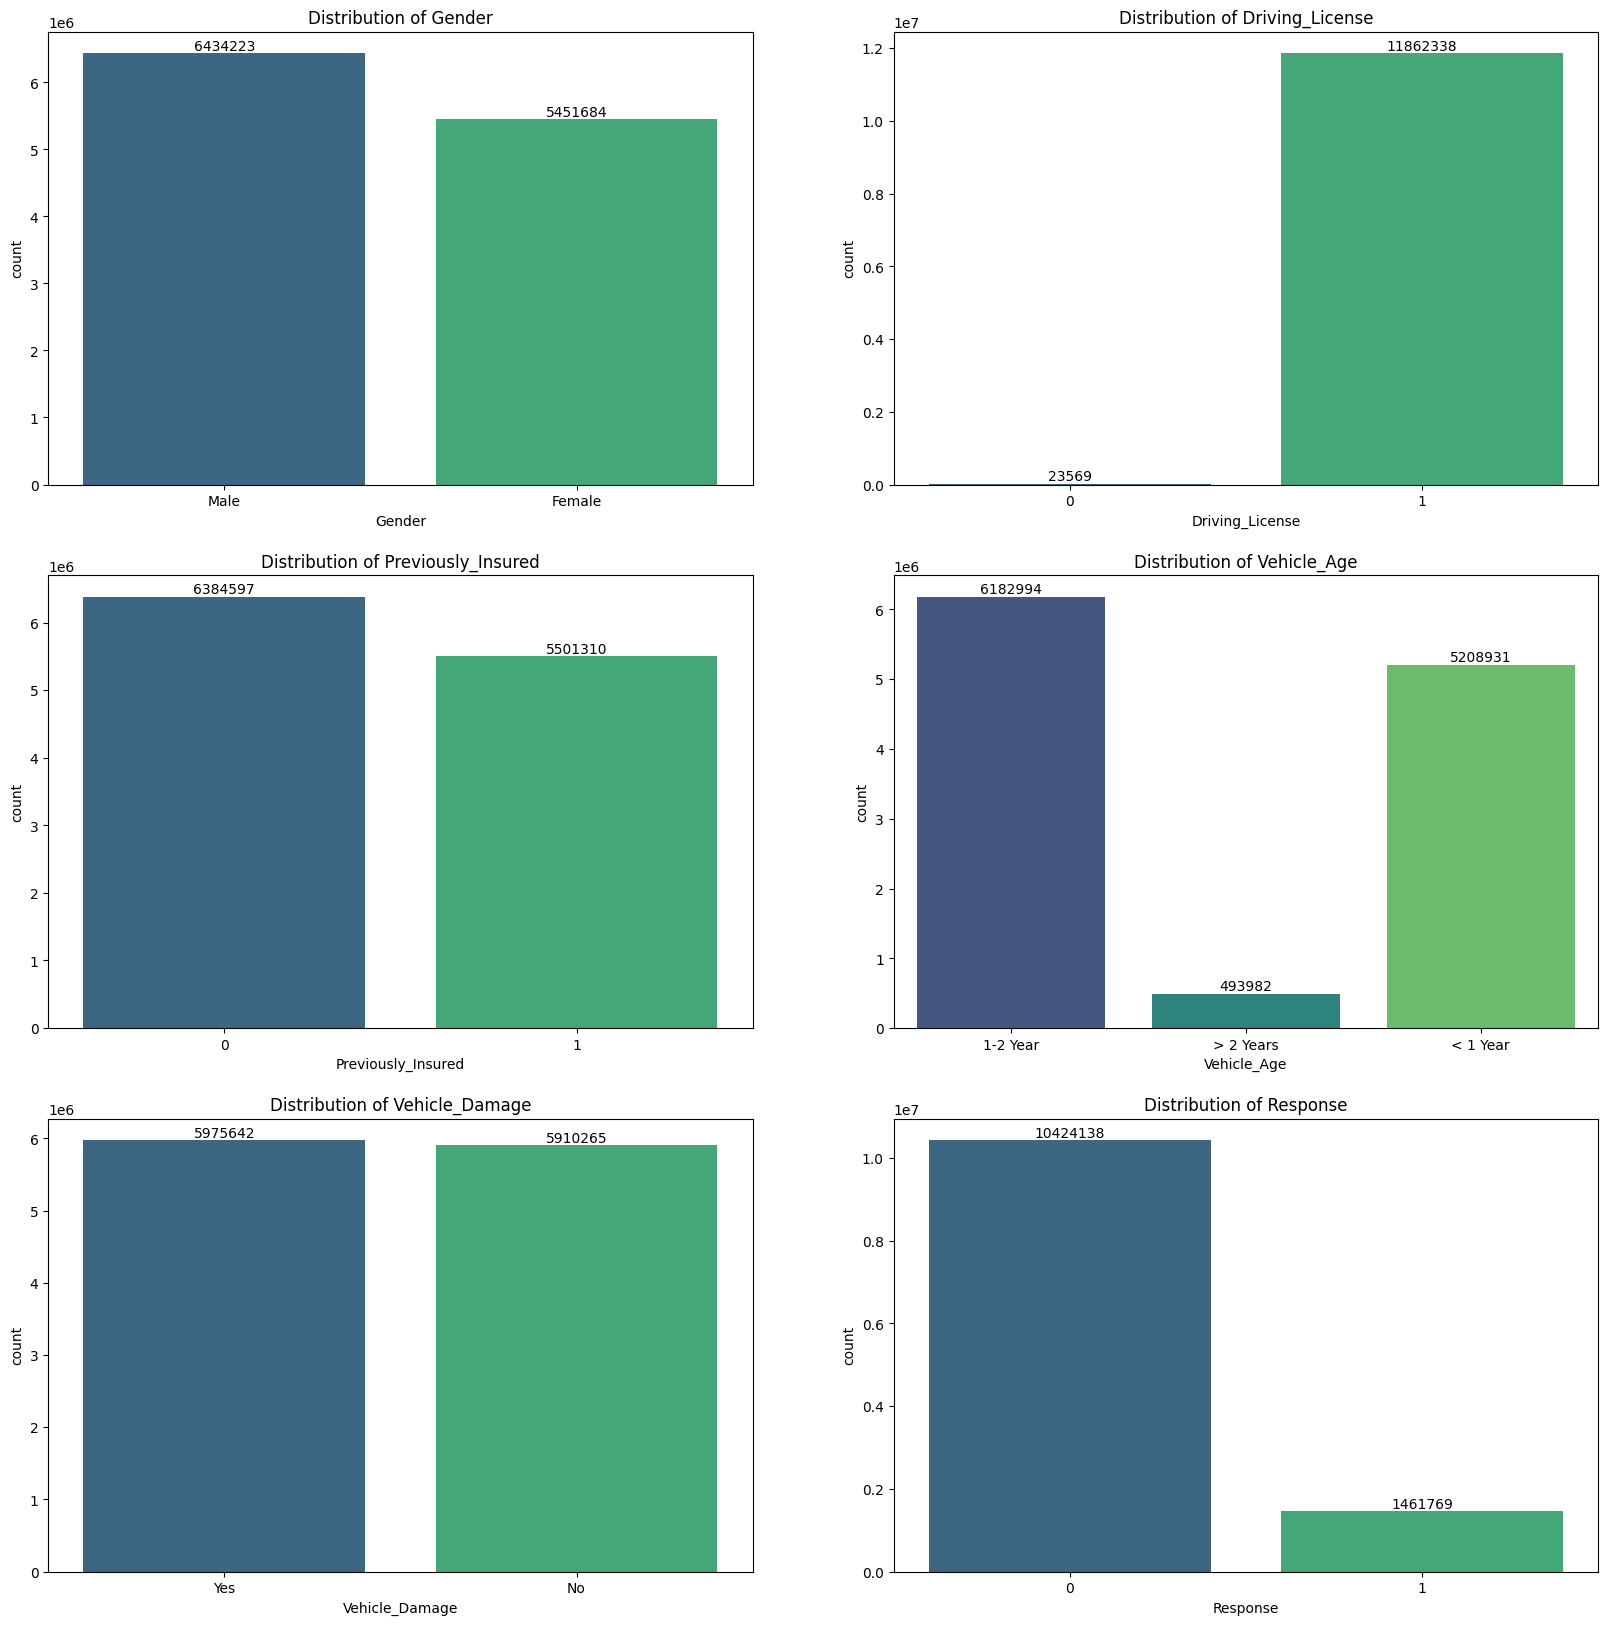

In [35]:
warnings.filterwarnings("ignore")

fig, axes = plt.subplots(3, 2, figsize=(20, 20))
axes = axes.flatten()

categorical_col = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Response']

for i, col in enumerate(categorical_col):
    sns.countplot(x=col, data=train, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xticklabels(axes[i].get_xticklabels())

    for p in axes[i].patches:
        axes[i].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=10, xytext=(0, 5),
                         textcoords='offset points')

# Preprocessing

## Label Encoding

In [9]:
# Gender
target_mapping = {'Male': 0, 'Female': 1}
train['Gender'] = train['Gender'].map(target_mapping)
test['Gender'] = test['Gender'].map(target_mapping)

In [10]:
# Vehicle_Damage
target_mapping = {'No': 0, 'Yes': 1}
train['Vehicle_Damage'] = train['Vehicle_Damage'].map(target_mapping)
test['Vehicle_Damage'] = test['Vehicle_Damage'].map(target_mapping)

In [11]:
# Vehicle_Age
target_mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}
train['Vehicle_Age'] = train['Vehicle_Age'].map(target_mapping)
test['Vehicle_Age'] = test['Vehicle_Age'].map(target_mapping)

## Changing dtype

In [12]:
# Convert float column to int type
train['Region_Code'] = train['Region_Code'].astype(int)
test['Region_Code'] = test['Region_Code'].astype(int)

train['Annual_Premium'] = train['Annual_Premium'].astype(int)
test['Annual_Premium'] = test['Annual_Premium'].astype(int)

train['Policy_Sales_Channel'] = train['Policy_Sales_Channel'].astype(int)
test['Policy_Sales_Channel'] = test['Policy_Sales_Channel'].astype(int)

## Feature Engineering

Thanks [VOPANI](https://www.kaggle.com/code/rohanrao/automl-grand-prix-1st-place-solution) for providing these new features

**Create New Features:**
   ```python
   df['Previously_Insured_Annual_Premium'] = pd.factorize((df['Previously_Insured'].astype(str) + df['Annual_Premium'].astype(str)).to_numpy())[0]
   df['Previously_Insured_Vehicle_Age'] = pd.factorize((df['Previously_Insured'].astype(str) + df['Vehicle_Age'].astype(str)).to_numpy())[0]
   df['Previously_Insured_Vehicle_Damage'] = pd.factorize((df['Previously_Insured'].astype(str) + df['Vehicle_Damage'].astype(str)).to_numpy())[0]
   df['Previously_Insured_Vintage'] = pd.factorize((df['Previously_Insured'].astype(str) + df['Vintage'].astype(str)).to_numpy())[0]
   ```

   - **Combining Columns:** Each line concatenates two columns as strings. For example, `(df['Previously_Insured'].astype(str) + df['Annual_Premium'].astype(str))` combines the `Previously_Insured` and `Annual_Premium` columns into a single string for each row.
   - **Factorizing Combined Strings:** The `pd.factorize()` function is then applied to the combined string arrays. Factorization converts each unique string into a unique integer. This is useful for converting categorical combinations into numerical values.
   - **Assigning New Features:** The factorized values are assigned to new columns in the DataFrame (`df`). Each new column represents a unique combination of the original columns.

In [13]:
# Concatenate train and test dataframes
df = pd.concat([train, test])

# Create the new features by factorizing the concatenated string columns
df['Previously_Insured_Annual_Premium'] = pd.factorize((df['Previously_Insured'].astype(str) + df['Annual_Premium'].astype(str)).to_numpy())[0]
df['Previously_Insured_Vehicle_Age'] = pd.factorize((df['Previously_Insured'].astype(str) + df['Vehicle_Age'].astype(str)).to_numpy())[0]
df['Previously_Insured_Vehicle_Damage'] = pd.factorize((df['Previously_Insured'].astype(str) + df['Vehicle_Damage'].astype(str)).to_numpy())[0]
df['Previously_Insured_Vintage'] = pd.factorize((df['Previously_Insured'].astype(str) + df['Vintage'].astype(str)).to_numpy())[0]

# Split the combined dataframe back into train and test
train = df.iloc[:train.shape[0]].reset_index(drop=True)
test = df.iloc[train.shape[0]:].reset_index(drop=True)

In [14]:
test = test.drop(['Response'], axis=1)

## Train Test Split

In [15]:
X = train.drop(['Response'], axis=1)
y = train.loc[:, 'Response'].values

In [16]:
# Split Data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=train.Response)

print("Training set shape (X, y):", X_train.shape, y_train.shape)
print("Testing set shape (X, y):", X_test.shape, y_test.shape)

Training set shape (X, y): (9508725, 14) (9508725,)
Testing set shape (X, y): (2377182, 14) (2377182,)


## Scaling

In [17]:
numeric_columns = ['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage',
                   'Previously_Insured_Annual_Premium', 'Previously_Insured_Vintage']

scaler = MinMaxScaler()

X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])
test[numeric_columns] = scaler.transform(test[numeric_columns])

# XGBoost

In [ ]:
'''
# Define the hyperparameters
params = {
    "colsample_bytree": 0.516652313273348,
    "enable_categorical": True,
    "learning_rate": 0.015,
    "max_depth": 9,
    "min_child_weight": 0.8567068904025429,
    "max_bin": 262143,
    "n_estimators": 150000,
    "objective": "binary:logistic",
    "eval_metric": "auc",  # XGBoost uses 'auc' for roc_auc_score
    "use_label_encoder": False
}

# Calculate the scale_pos_weight parameter
# scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
# params['scale_pos_weight'] = scale_pos_weight

# Initialize the XGBoost classifier with the specified parameters
xgb_model = xgb.XGBClassifier(**params)

# Fit the model to the training data
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=True)
'''

Thanks [RIZA TEMIZEL](https://www.kaggle.com/code/rzatemizel/single-model-baseline-xgboost/notebook) for providing hyperparameters of XGB

In [24]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.03,  # Reduced learning rate
    'alpha': 0.1,  # Slightly reduced regularization
    'subsample': 0.85,  # Increased subsample fraction
    'colsample_bytree': 0.45,  # Adjusted colsample_bytree
    'max_depth': 12,  # Reduced max depth
    'min_child_weight': 10,  # Slightly increased to control overfitting
    'gamma': 1e-6,  # Slightly increased gamma
    'random_state': 42,
    'max_bin': 30000,  # Reduced max_bin from 50000
    'enable_categorical': True,
    'n_estimators': 11000,  # Keep high for early stopping
    'tree_method': 'hist'
}

model = xgb.XGBClassifier(**params)
XGB = model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_test, y_test)],  
    early_stopping_rounds=50, 
    verbose=50
)

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.82651
[50]	validation_0-auc:0.87405
[100]	validation_0-auc:0.87735
[150]	validation_0-auc:0.87910
[200]	validation_0-auc:0.87997
[250]	validation_0-auc:0.88073
[300]	validation_0-auc:0.88146
[350]	validation_0-auc:0.88204
[400]	validation_0-auc:0.88293
[450]	validation_0-auc:0.88372
[500]	validation_0-auc:0.88432
[550]	validation_0-auc:0.88501
[600]	validation_0-auc:0.88540
[650]	validation_0-auc:0.88583
[700]	validation_0-auc:0.88619
[750]	validation_0-auc:0.88650
[800]	validation_0-auc:0.88684
[850]	validation_0-auc:0.88713
[900]	validation_0-auc:0.88742
[950]	validation_0-auc:0.88772
[1000]	validation_0-auc:0.88801
[1050]	validation_0-auc:0.88819
[1100]	validation_0-auc:0.88843
[1150]	validation_0-auc:0.88859
[1200]	validation_0-auc:0.88874
[1250]	validation_0-auc:0.88888
[1300]	validation_0-auc:0.88901
[1350]	validation_0-auc:0.88912
[1400]	validation_0-auc:0.88924
[1450]	validation_0-auc:0.88938
[1500]	validation_0-auc:0.88945
[1550]	validation_0-auc:0.88953

In [26]:
# Predict probabilities for the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate the roc_auc_score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc}")

ROC AUC Score: 0.8913730338673287


# Prediction

In [27]:
pred = model.predict_proba(test)[:, 1]

output = pd.DataFrame({'id': submission_id, 'Response': pred})
output.to_csv('sub_v1.csv', index=False)

In [28]:
output = pd.DataFrame({'id': submission_id, 'Response': pred})
output.to_csv('submission.csv', index=False)